In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import re
import nltk
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import LearningRateScheduler
from keras.layers import Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/My Drive/labeled_data.csv")
tweets = data.iloc[:, -1:]
labels = data.iloc[:, -2:-1]
y = np.zeros((len(labels), 3))
for i in range(len(labels)):
  y[i, labels['class'][i]] = 1

In [ ]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
corpus = []
for index in range(len(tweets['tweet'])):
    review = re.sub('!', '', tweets['tweet'][index])
    review = re.sub('RT', '', review)
    review = re.sub('@\S*', '', review)
    review = re.sub('&amp;', '', review)
    review = re.sub('[\.][\.]+', '', review)
    review = re.sub('#', '', review)
    review = re.sub('&\S+', '', review)
    review = re.sub('http\S+', '', review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    final_review = ' '.join(review)
    corpus.append(final_review)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size = 0.1)
print(len(X_train))

22304


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
vocab_length = len(tokenizer.word_index) + 1

In [ ]:
embedded_sequences = tokenizer.texts_to_sequences(X_train)

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
#print(length_long_sentence)

from keras.preprocessing.sequence import pad_sequences
padded_sentences = pad_sequences(embedded_sequences, padding = 'post', maxlen = length_long_sentence)
#print(embedded_sequences)
#print(padded_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#!wget 'http://nlp.stanford.edu/data/glove.6B.zip'

--2020-08-07 11:00:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-07 11:00:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-07 11:00:01--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#!unzip '/content/glove.6B.zip'

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embeddings_dictionary = dict()
embedding_file = open('/content/glove.6B.300d.txt')

In [ ]:
for line in embedding_file:
  records = line.split()
  word = records[0]
  vector = np.asarray(records[1:], dtype = 'float32')
  embeddings_dictionary[word] = vector

embedding_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in tokenizer.word_index.items():
  embeddings_vector = embeddings_dictionary.get(word)
  if embeddings_vector is not None:
    embedding_matrix[index] = embeddings_vector

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs['acc'] >= 0.975:
      print("\nAccuracy greater than 95%. Stopping.....")
      self.model.stop_training = True
earlystop = keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 20, mode = 'max', restore_best_weights = True)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_length, 300, input_length = length_long_sentence, weights = [embedding_matrix], trainable = False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
model.add(Bidirectional(LSTM(units = 100)))
model.add(Dense(1, activation='relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 47, 300)           5451300   
_________________________________________________________________
bidirectional (Bidirectional (None, 47, 200)           320800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 6,013,154
Trainable params: 561,854
Non-trainable params: 5,451,300
________________________________________

In [ ]:
model.compile(optimizer = keras.optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
test_set = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_set, maxlen = length_long_sentence, padding = 'post', truncating='pre')

In [ ]:
history = model.fit(padded_sentences, y_train, epochs = 100, callbacks = [earlystop], validation_data= (test_padded, y_test))

Epoch 1/100
697/697 [==============================] - 142s 204ms/step - loss: 0.7356 - acc: 0.7752 - val_loss: 0.5359 - val_acc: 0.7592
Epoch 2/100
697/697 [==============================] - 140s 200ms/step - loss: 0.4436 - acc: 0.8126 - val_loss: 0.4165 - val_acc: 0.8544
Epoch 3/100
697/697 [==============================] - 139s 199ms/step - loss: 0.3678 - acc: 0.8806 - val_loss: 0.3899 - val_acc: 0.8616
Epoch 4/100
697/697 [==============================] - 139s 200ms/step - loss: 0.3331 - acc: 0.8906 - val_loss: 0.3824 - val_acc: 0.8653
Epoch 5/100
697/697 [==============================] - 138s 197ms/step - loss: 0.3052 - acc: 0.9007 - val_loss: 0.3898 - val_acc: 0.8677
Epoch 6/100
697/697 [==============================] - 138s 198ms/step - loss: 0.2809 - acc: 0.9090 - val_loss: 0.4164 - val_acc: 0.8661
Epoch 7/100
697/697 [==============================] - 138s 198ms/step - loss: 0.2594 - acc: 0.9141 - val_loss: 0.4548 - val_acc: 0.8649
Epoch 8/100
697/697 [====================

In [ ]:
model.predict([test_padded])

array([[9.66233462e-02, 1.19050875e-01, 7.84325838e-01],
       [1.33526787e-01, 8.06720436e-01, 5.97528219e-02],
       [1.47349993e-02, 9.85182583e-01, 8.24432136e-05],
       ...,
       [1.18284794e-02, 9.88127410e-01, 4.41002594e-05],
       [7.69771859e-02, 9.12000313e-02, 8.31822753e-01],
       [1.75581038e-01, 4.51248080e-01, 3.73170912e-01]], dtype=float32)

In [ ]:
model.evaluate([test_padded], y_test)

78/78 [==============================] - 4s 54ms/step - loss: 0.3898 - acc: 0.8677


[0.3897678554058075, 0.8676885962486267]

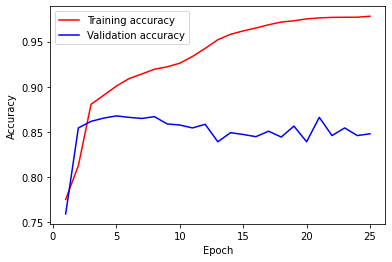

In [ ]:
training_loss = history.history['acc']
validation_loss = history.history['val_acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, color = 'red')
plt.plot(epoch_count, validation_loss, color = 'blue')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/hatespeech.h5')